In [1]:
import os
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as scio
import h5py
import scipy
import scipy.io as sio
import scipy.misc as smisc
from scipy import signal
import glob
import copy
import re 

from scipy import optimize
from skimage import feature
from pylab import *

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from scipy.io import loadmat

%load_ext jupyternotify


def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

<IPython.core.display.Javascript object>

In [2]:
numbers = re.compile(r'(\d+)')
def map01(mat):
    return (mat - mat.min())/(mat.max() - mat.min())
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def check_finish(datadirc, pos,depth):
    # navigate to the 4D data npy arrays and check simulation state
    # pos is any position in real space
    # depth is 2 digit of depth
    f = h5py.File(datadirc, 'r')
    a = f['4DSTEM_simulation']
    b = a['data']
    c = b['datacubes']
    print(c.keys())
    d = c['CBED_array_depth00'+depth]
    e = d['datacube']
    print(e.shape)
    plt.imshow(e[:,:,pos,pos], origin = "lower")
    plt.colorbar()
    plt.show()

def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

<KeysViewHDF5 ['CBED_array_depth0000', 'CBED_array_depth0001', 'CBED_array_depth0002', 'CBED_array_depth0003', 'CBED_array_depth0004', 'CBED_array_depth0005']>
(67, 67, 488, 480)


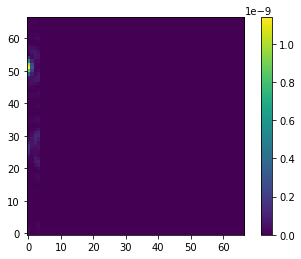

In [9]:
check_finish('/srv/home/jwei74/Prismatic/Si110/output/Si_110', 0,'05')
#check_finish('/srv/home/jwei74/Prismatic/STO_pxsize/output/px',0,'25')

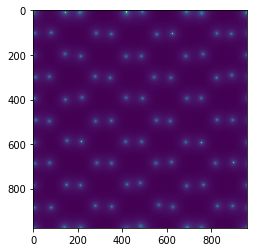

In [5]:
with h5py.File('/srv/home/jwei74/Prismatic/Si110/output/Si_110', 'r') as f:
    a = f['4DSTEM_simulation/data/realslices/ppotential/realslice']
    plt.imshow(a[:,:,3]+a[:,:,4])

### Find center of the DP

(105, 105, 1736, 1736)
(336, 336)


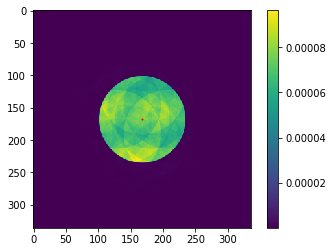

In [103]:
hdf5dirc = '/srv/home/jwei74/Prismatic/WS2_2H/output/WS2_25pm'
f = h5py.File(hdf5dirc, 'r')
a = f['/4DSTEM_simulation/data/datacubes/CBED_array_depth0003/datacube/']
kx,ky,rx,ry = a.shape
print(a.shape)

sample = a[1,1,700:1036,700:1036] # for the WS2
#sample = a[1,1,:,:]
print(sample.shape)
plt.figure()
plt.imshow(sample)
plt.colorbar()
plt.scatter(167,167,s = 1, c = 'r')
plt.show()

#####

imgdata = (map01(sample)*255).astype('uint8')
img = Image.fromarray(imgdata, mode = 'L')
img.save('/srv/home/jwei74/sample.tif')


### Add source size

In [104]:
%%notify

Data_4D = a[:,:,700:1036,700:1036]
print(Data_4D.shape)
print(Data_4D.dtype)


(105, 105, 336, 336)
float32


<IPython.core.display.Javascript object>

(105, 105, 336, 336)


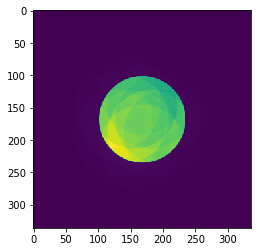

In [105]:
source_size = 80
px_size = 25
array_size = Data_4D.shape[:2]
sigma = (source_size/px_size)/(2.355)
kernel = gaussKernel(sigma,array_size[0])
fkernel = np.fft.fft2(kernel)
kx,ky = Data_4D.shape[2:4]
#initialize result array
result = np.zeros(Data_4D.shape,dtype=np.float32)
result = np.squeeze(result)
for k in range(kx):
    for l in range(ky):
        #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
        result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(Data_4D[:,:,k,l]))).real

        
print(result.shape)
plt.imshow(result[1,1,:,:])

In [106]:
##################
# Basic reconstruction
##################

# if HAADF is 50.50-308.25, semiconvergence is 24
# 34/24 = inner/50.5 inner = 71.5
# 34/24 = outer/308.25 inner = 437

ABF_radius = 34
BF_radius = 68
ADF_radius = 200
HAADFradius = [72, 437]


rx,ry,kx,ky = Data_4D.shape
ADF = np.zeros((rx,ry))
HAADF = np.zeros((rx,ry))
BF = np.zeros((rx,ry))
ABF = np.zeros((rx,ry))
PACBED = np.zeros((kx,ky))
kx2,ky2 = np.meshgrid(kx,ky)

for ix in range(rx):
    for iy in range(ry):
        frame = result[ix,iy,:,:]
        center_x = 193
        center_y = 193
        distance_from_center = np.sqrt((kx2 - center_x)**2 + (ky2-center_y)**2)
        
        ADF_mask = (distance_from_center > BF_radius) & (distance_from_center <= ADF_radius)
        ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
        BF_mask = distance_from_center <= BF_radius
        HAADF_mask = (distance_from_center > HAADFradius[0]) & (distance_from_center <= HAADFradius[1])
        
        BF[ix,iy] = (frame*BF_mask).sum()
        ABF[ix,iy] = (frame*ABF_mask).sum()
        ADF[ix,iy] = (frame*ADF_mask).sum()
        HAADF[ix,iy] = (frame*HAADF_mask).sum()
        PACBED = PACBED + frame
        
        PACBED = PACBED + frame

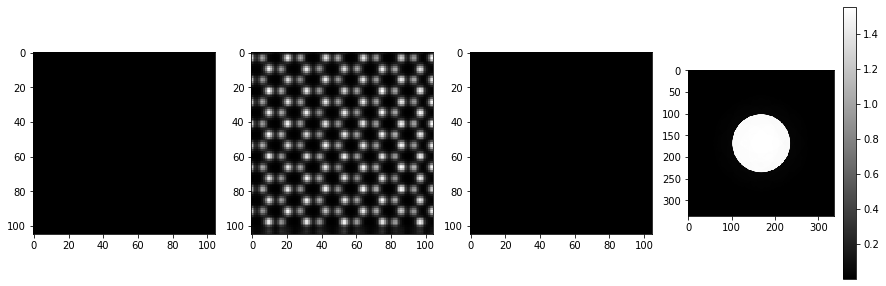

float64


In [107]:
fig = plt.figure(figsize = (15,5))
fig.add_subplot(141)
plt.imshow(ADF, cmap = 'gray')
fig.add_subplot(142)
plt.imshow(1-HAADF,cmap = 'gray')
fig.add_subplot(143)
plt.imshow(ABF,cmap = 'gray')
fig.add_subplot(144)
plt.imshow(PACBED, cmap = 'gray')
plt.colorbar()
plt.show()

print(HAADF.dtype)

float64


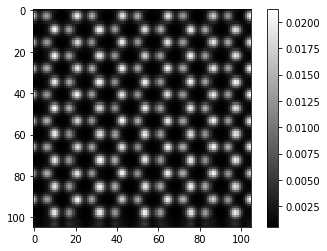

In [108]:
plt.imshow(1-HAADF,cmap = 'gray')
print(HAADF.dtype)
plt.colorbar()

# save the float64 haadf image to mat file
sio.savemat('/srv/home/jwei74/Prismatic/WS2_2H/output/WS2_25pm_s80.mat',{'WS2': 1-HAADF})

(130, 130)


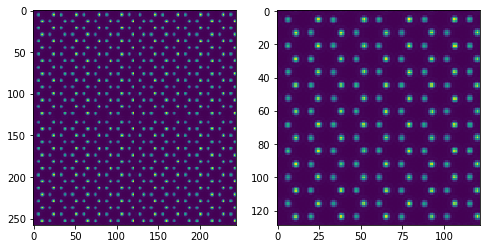

In [62]:
## Crop image to be correct repo unit for CreatPhantom algorithom
## edge in the middle of two atoms

a = loadmat('/srv/home/jwei74/Prismatic/WS2_2H/output/WS2_20pm.mat')
array = a['WS2']
print(array.shape)

newarray = array[1:,4:126]
pad = np.vstack((np.hstack((newarray,newarray)),np.hstack((newarray,newarray))))
fig = plt.figure(figsize = (8,8))
fig.add_subplot(121)
plt.imshow(pad)
fig.add_subplot(122)
plt.imshow(newarray)

[] [] []


/srv/home/jwei74/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/srv/home/jwei74/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

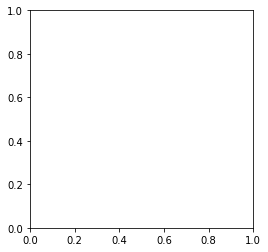

In [28]:
## Find center of the DP
bw = 1.0*(sample > 0.0001)
#selem = disk(5)
#bw2 = closing(bw, selem)
edges = feature.canny(bw)

sample = sample*bw
sample = sample.astype('uint8')
temp = edges.astype('uint8')
# plt.imshow(sample)
# plt.colorbar()

image = sample

# Detect two radii
# the range should be loose both direction
hough_radii = np.arange(0,100,1)

hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=5)

print(cx,cy,radii)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)
# circy, circx = circle_perimeter(290,262,181)
image[circy, circx] = (220, 20, 20)

# for center_y, center_x, radius in zip(cy, cx, radii):
#     circy, circx = circle_perimeter(center_y, center_x, radius)
#     image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print(cx,cy,radii)